# PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cluster_utils as cu
import db_utils as db
import os
import pandas as pd
import importlib

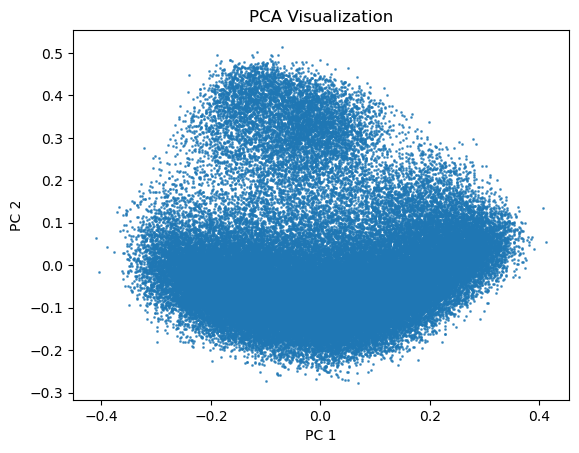

In [2]:
# get folder outside current directory (project folder)
current_dir = os.path.dirname(os.getcwd())
proj_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Load the 2D coordinates
coordinates = np.load(proj_dir + "/dataset/pubmed_20241121_working_memory.embd.pca5.npy")

# Scatter plot
plt.scatter(coordinates[:, 0], coordinates[:, 1], s=1, alpha=0.7)
plt.title("PCA Visualization")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()


In [3]:
coordinates.shape

(73763, 5)

In [4]:
# keep only 2 PCs

coordinates = coordinates[:, :2]

## Clustering

### hdbscan

In [3]:
%pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


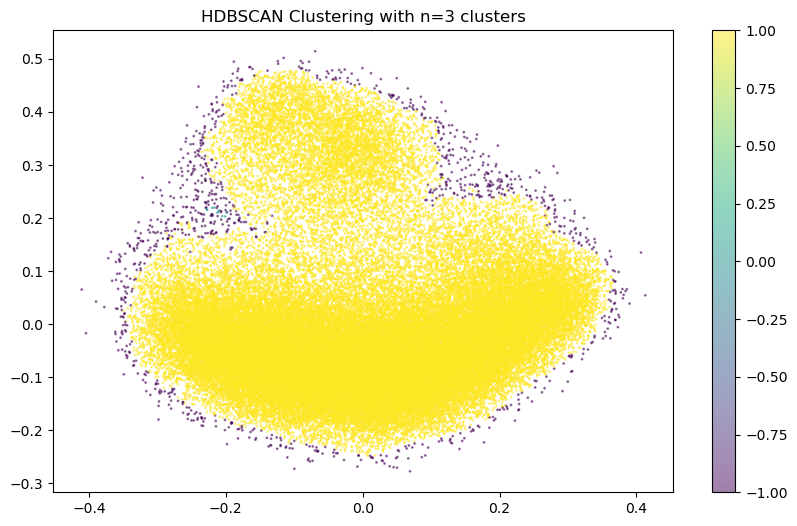

In [5]:
importlib.reload(cu)
hdbscan_labels = cu.hdbscan_cluster(coordinates, min_cluster_size=10, plot=1, dim3=False)

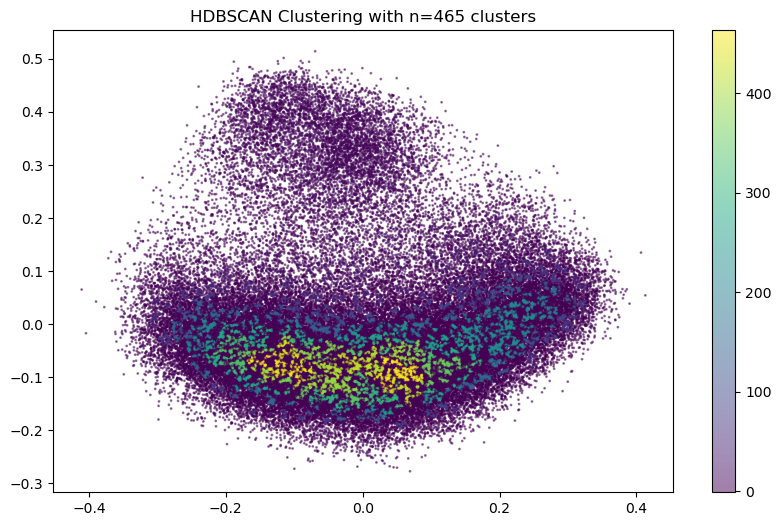

In [6]:
importlib.reload(cu)
hdbscan_labels = cu.hdbscan_cluster(coordinates, 
                                    min_cluster_size=20, min_samples=10, 
                                    plot=1, dim3=False)

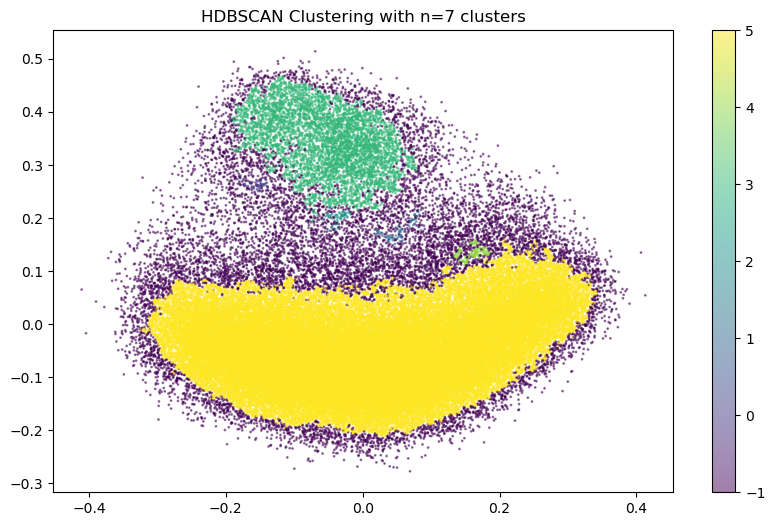

In [7]:
importlib.reload(cu)
hdbscan_labels = cu.hdbscan_cluster(coordinates, 
                                    min_cluster_size=50, min_samples=20, 
                                    plot=1, dim3=False)

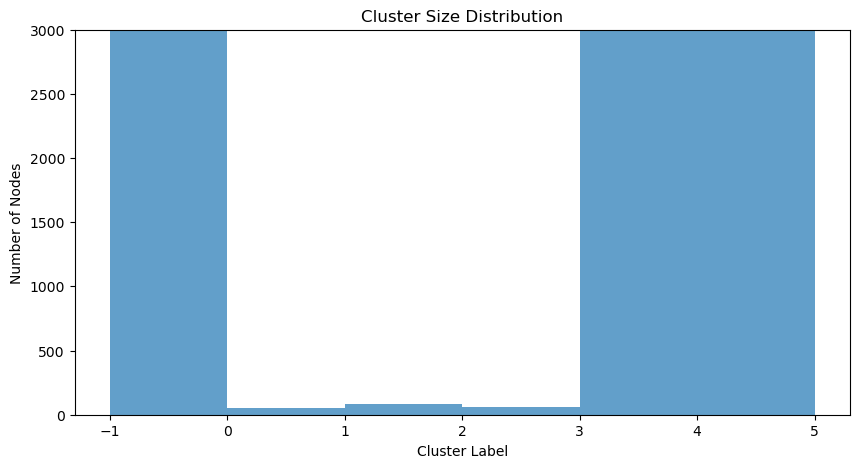

In [8]:
# plot cluster size distribution

plt.figure(figsize=(10, 5))
plt.hist(hdbscan_labels, bins=np.arange(-1, hdbscan_labels.max()+1, 1), alpha=0.7)
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Nodes")
plt.ylim(0, 3000)
plt.show()

### K-means clustering

Let's start with a random number of clusters... (use same # found from hdbscan)

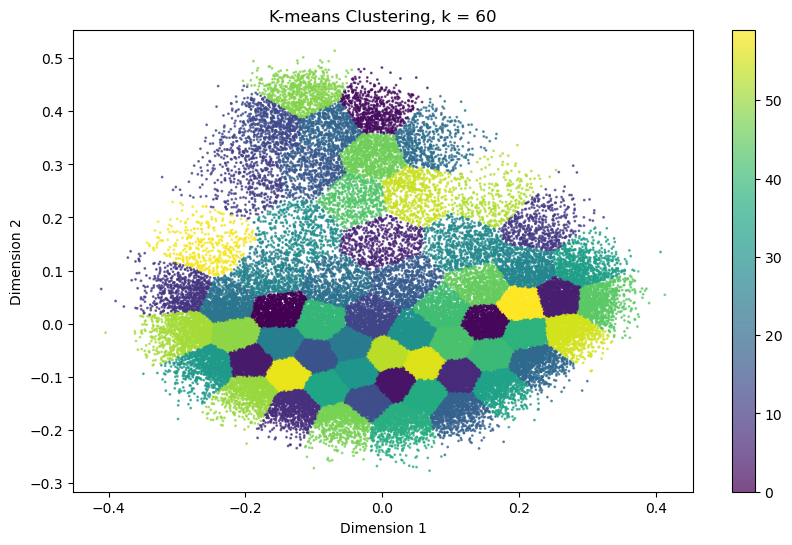

In [10]:
# Plot the clusters
importlib.reload(cu)
kmeans_labels = cu.kmeans_cluster(coordinates, n_clusters=60, plot=1, dim3=False)

## Stats

In [11]:
df = pd.read_csv(
            proj_dir + "/dataset/pubmed_20241121_working_memory.raw",
            sep="\t"
        )

df.head()

pmid                                              title  \
0   710  Effect of two weeks' treatment with thioridazi...   
1  2563  EEG sleep studies of insomniacs under flunitra...   
2  2812  Alcohol and backward masking of visual informa...   
3  2813  Recovery of verbal short-term memory in alcoho...   
4  6497  Effect of counterconditioning on test anxiety ...   

                             journal  year  \
0                Psychopharmacologia  1975   
1   International pharmacopsychiatry  1975   
2      Journal of studies on alcohol  1976   
3      Journal of studies on alcohol  1976   
4  Journal of educational psychology  1976   

                                            abstract  \
0  Forty paid healthy male students participated ...   
1  This study investigates the effect of flunitra...   
2  Alcohol increased the time necessary to transf...   
3  When given a short-term memory distractor test...   
4                                                NaN   

                                          mesh_terms  \
0  Adult;Animals;Anti-Anxiety Agents;Bromazepam;C...   
1  Adult;Anti-Anxiety Agents;Dreams;Electroenceph...   
2  Adult;Dose-Response Relationship, Drug;Ethanol...   
3  Adult;Age Factors;Aged;Alcohol Amnestic Disord...   
4  Achievement;Adolescent;Anxiety;Behavior Therap...   

                                         mesh_topics  
0  pharmacology;blood;pharmacology;pharmacology;p...  
1  therapeutic use;drug effects;adverse effects;p...  
2             pharmacology;drug effects;drug effects  
3  complications;complications;drug effects;drug ...  
4                                                NaN

In [12]:
importlib.reload(db)
points_df = db._get_points_df(None,
                  path_tsv = proj_dir + "/dataset/pubmed_20241121_working_memory.raw",
                  delimiter = "\t",
                  points = coordinates,
                  )
points_df.head()

* loaded df
* merged embds to df


pmid                                         mesh_terms  \
0   710  Adult;Animals;Anti-Anxiety Agents;Bromazepam;C...   
1  2563  Adult;Anti-Anxiety Agents;Dreams;Electroenceph...   
2  2812  Adult;Dose-Response Relationship, Drug;Ethanol...   
3  2813  Adult;Age Factors;Aged;Alcohol Amnestic Disord...   
4  6497  Achievement;Adolescent;Anxiety;Behavior Therap...   

                                         mesh_topics         x         y  
0  pharmacology;blood;pharmacology;pharmacology;p...  0.213352 -0.024615  
1  therapeutic use;drug effects;adverse effects;p...  0.193741  0.061694  
2             pharmacology;drug effects;drug effects -0.021743 -0.021289  
3  complications;complications;drug effects;drug ...  0.043184 -0.102067  
4                                                NaN -0.002772 -0.019995

### kmeans

In [13]:
print(np.unique(kmeans_labels))
# print(np.sum(hdbscan_labels == -1))
print(len(kmeans_labels))
# print(np.sum(hdbscan_labels == -1) / len(hdbscan_labels))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
73763


In [14]:
from collections import defaultdict

cluster_terms = defaultdict(list)
for index, label in enumerate(kmeans_labels):
# for index, label in enumerate(hdbscan_labels):
    # skip if cluster -1 (noise)
    if label == -1:
        continue

    mesh_terms = points_df.iloc[index, points_df.columns.get_loc("mesh_terms")]

    # Check if the 'mesh_terms' is NaN or missing
    if pd.isna(mesh_terms):
        continue  # Skip this iteration if mesh_terms is NaN

    # Otherwise, split the terms and add them to the cluster_terms
    cluster_terms[label].extend(
        [t for t in mesh_terms.split(";")]
    )

In [15]:
cluster_terms

defaultdict(list,
            {38: ['Adult',
              'Animals',
              'Anti-Anxiety Agents',
              'Bromazepam',
              'Chlorpromazine',
              'Clinical Trials as Topic',
              'Drug Synergism',
              'Ethanol',
              'Humans',
              'Male',
              'Memory, Short-Term',
              'Paired-Associate Learning',
              'Psychotropic Drugs',
              'Rabbits',
              'Receptors, Drug',
              'Sulpiride',
              'Thioridazine',
              'Aging',
              'Animals',
              'Caffeine',
              'Central Nervous System Stimulants',
              'Female',
              'Haplorhini',
              'Macaca mulatta',
              'Male',
              'Memory, Short-Term',
              'Methylphenidate',
              'Nicotinic Acids',
              'Pemoline',
              'Pentylenetetrazole',
              'Adult',
              'Anti-Anxiety Agents',
   

In [16]:
# Step 1: Extract unique values across all lists
unique_values = set(value for values in cluster_terms.values() for value in values)

# Step 2: Create a mapping of each unique value to an index
value_to_index = {value: idx for idx, value in enumerate(sorted(unique_values))}

# Step 3: Update the original dictionary to replace values with their indices
indexed_dict = {key: [value_to_index[value] for value in values] for key, values in cluster_terms.items()}

print(indexed_dict)

{38: [306, 645, 696, 1539, 2150, 2313, 3423, 3906, 5368, 6587, 6794, 8185, 9314, 9489, 9712, 10994, 11318, 354, 645, 1643, 1974, 4111, 4952, 6532, 6587, 6794, 6934, 7702, 8352, 8369, 306, 696, 2130, 3405, 3906, 5368, 6231, 6786, 6794, 7780, 8129, 11191, 11381, 645, 1490, 4111, 6786, 6794, 7609, 7639, 9580, 12268, 302, 345, 913, 992, 1030, 1199, 1497, 1810, 4111, 5368, 6587, 6794, 7029, 9599, 11976, 144, 145, 467, 645, 2171, 2173, 3010, 5368, 6789, 9580, 10229, 11073, 345, 2313, 3010, 4111, 4405, 5368, 6587, 6786, 7029, 7410, 7619, 9274, 9599, 306, 370, 371, 1199, 1225, 1490, 2154, 3769, 4221, 5049, 5368, 6587, 6794, 8627, 9599, 12188, 264, 306, 1401, 2313, 2329, 3236, 3390, 3848, 4111, 5049, 5368, 5459, 6587, 7029, 8711, 9274, 9925, 10907, 737, 1490, 3078, 5368, 5812, 6794, 11397, 306, 1030, 3362, 4111, 5368, 5474, 6587, 6794, 7029, 7722, 9599, 10525, 11152, 445, 1199, 1255, 1966, 2313, 2376, 3603, 3673, 4111, 5368, 6587, 7029, 8215, 8711, 9274, 12081, 306, 2313, 3160, 3603, 4125, 5368

In [17]:
# index to value
index_to_value = {idx: value for value, idx in value_to_index.items()}
# index_to_value

In [18]:
print(len(indexed_dict[0]))
print(len(np.unique(indexed_dict[0])))

13665
921


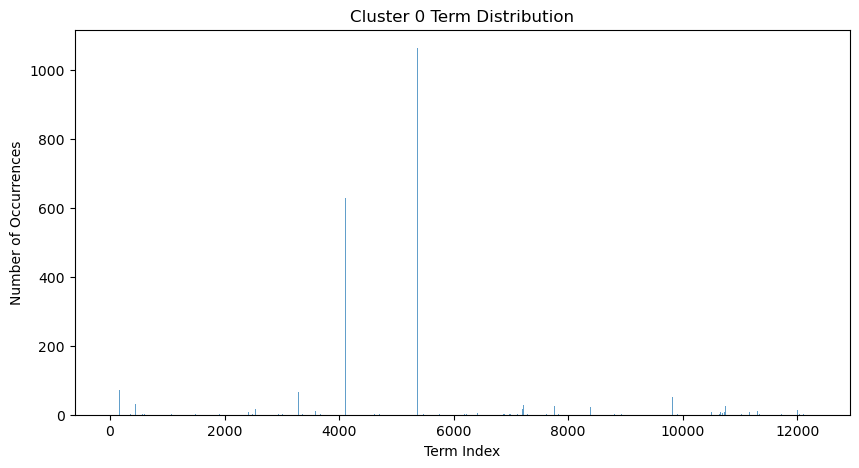

In [19]:
# plot the first key in the dictionary
plt.figure(figsize=(10, 5))
plt.hist(indexed_dict[0], bins=np.arange(0, len(value_to_index), 1), alpha=0.7)
plt.title("Cluster 0 Term Distribution")
plt.xlabel("Term Index")
plt.ylabel("Number of Occurrences")
# plt.ylim(0, 125)
plt.show()

In [20]:
# get the top 5 terms for each cluster
for clus in indexed_dict:
    term_idx = indexed_dict[clus]
    term_freq = np.bincount(term_idx)
    most_freq_idx = np.argsort(term_freq)[-30:-20]
    most_freq_term = [index_to_value[idx] for idx in most_freq_idx]
    print(f"Cluster {clus}: {most_freq_term} ({term_freq[most_freq_idx]} occurrences)")

Cluster 38: ['Time Factors', 'Adolescent', 'Reaction Time', 'Young Adult', 'Prefrontal Cortex', 'Psychomotor Performance', 'Rats, Sprague-Dawley', 'Disease Models, Animal', 'Dose-Response Relationship, Drug', 'Rats, Wistar'] ([115 117 124 126 127 133 137 145 152 154] occurrences)
Cluster 59: ['Analysis of Variance', 'Alzheimer Disease', 'Mice, Knockout', 'Aged', 'Neuropsychological Tests', 'Prefrontal Cortex', 'Motor Activity', 'Neurons', 'Time Factors', 'Dose-Response Relationship, Drug'] ([ 86  89  92  93  93 102 105 113 115 116] occurrences)
Cluster 12: ['Memory Disorders', 'Space Perception', 'Nerve Net', 'Time Factors', 'Learning', 'Neural Pathways', 'Mental Recall', 'Electroencephalography', 'Psychomotor Performance', 'Reaction Time'] ([ 75  76  81  83  86  86  93 103 109 114] occurrences)
Cluster 3: ['Prefrontal Cortex', 'Analysis of Variance', 'Aging', 'Schizophrenic Psychology', 'Brain Mapping', 'Case-Control Studies', 'Cognitive Dysfunction', 'Aged, 80 and over', 'Psychomotor

In [21]:
from scipy.stats import mannwhitneyu

In [22]:
# perform Mann-Whitney U tests for all combos of clusters

# Create a list of cluster labels
cluster_labels = list(indexed_dict.keys())

p_values = np.ones((len(cluster_labels), len(cluster_labels)))

for i, label1 in enumerate(cluster_labels):
    for j, label2 in enumerate(cluster_labels):
        if i >= j:
            continue

        # Perform Mann-Whitney U test (non-parametric test)
        u_stat, p_value = mannwhitneyu(indexed_dict[label1], indexed_dict[label2])
        p_values[i, j] = p_value
        p_values[j, i] = p_value


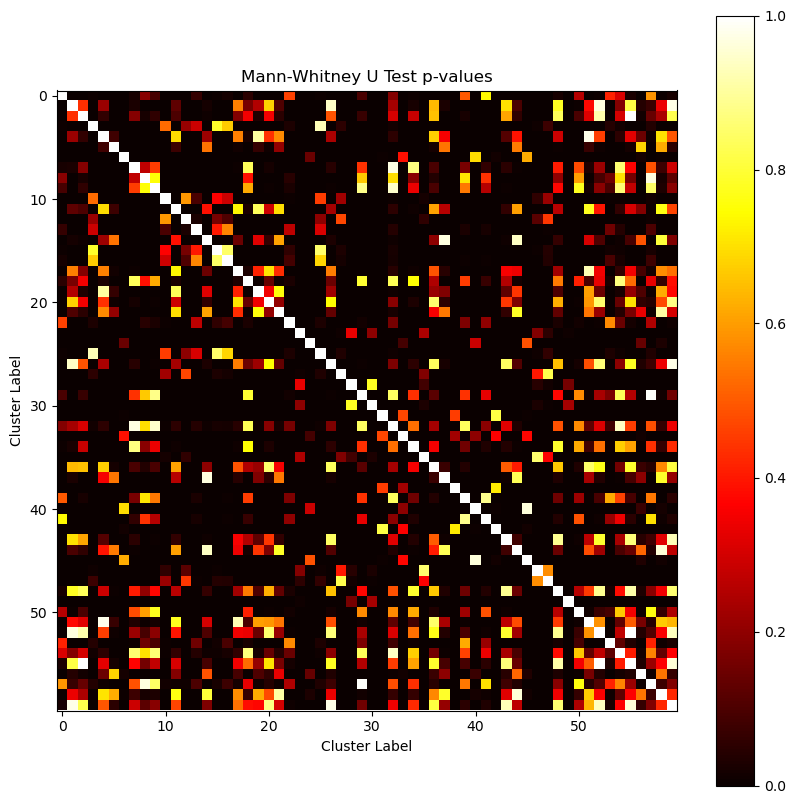

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(p_values, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Mann-Whitney U Test p-values")
plt.xlabel("Cluster Label")
plt.ylabel("Cluster Label")
plt.show()

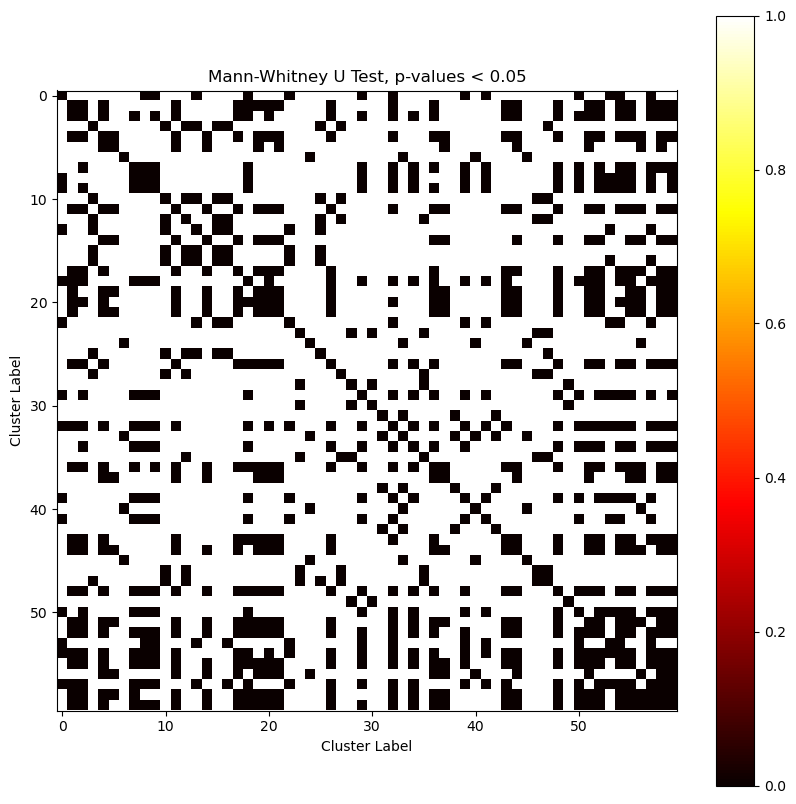

In [24]:
p_values_sig = np.where(p_values < 0.05, 1, 0)

plt.figure(figsize=(10, 10))
plt.imshow(p_values_sig, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Mann-Whitney U Test, p-values < 0.05")
plt.xlabel("Cluster Label")
plt.ylabel("Cluster Label")
plt.show()

In [25]:
# percentage of significant p-values
np.sum(p_values_sig) / (len(cluster_labels) ** 2)

0.7305555555555555